# Tetrominoes

Sample keys:
```
image       uint8   [35, 35, 3]
mask        uint8   [4, 35, 35]
visibility  bool    [4]
shape       uint8   [4]
x           uint8   [4]
y           uint8   [4]
color       float32 [4, 3]
```

Object in position `0` is always the background.

Total samples: 1M

https://github.com/deepmind/multi_object_datasets

In [1]:
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

from pathlib import Path

import h5py
import matplotlib.pyplot as plt
import multi_object_datasets.tetrominoes
import numpy as np
import pandas as pd
import tensorflow as tf
import tqdm

tf.get_logger().setLevel("WARNING")

num_cpus = 16
batch_size = 1000
data_root = Path.home() / "multi-object-datasets" / "tetrominoes"
tfr_path = data_root / "tetrominoes_train.tfrecords"
h5_path = tfr_path.with_suffix(".h5")

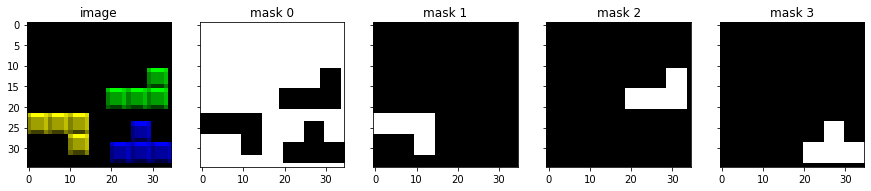

,visibility,x,y,shape,color_RGB
0,True,0,0,0,"[0.0, 0.0, 0.0]"
1,True,22,0,6,"[1.0, 1.0, 0.0]"
2,True,11,19,5,"[0.0, 1.0, 0.0]"
3,True,24,20,15,"[0.0, 0.0, 1.0]"


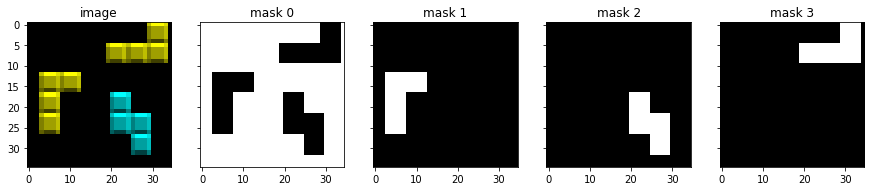

,visibility,x,y,shape,color_RGB
0,True,0,0,0,"[0.0, 0.0, 0.0]"
1,True,12,3,9,"[1.0, 1.0, 0.0]"
2,True,17,20,14,"[0.0, 1.0, 1.0]"
3,True,0,19,5,"[1.0, 1.0, 0.0]"


In [2]:
def show_sample(sample):
    fig, axs = plt.subplots(
        1,
        1 + sample["mask"].shape[0],
        figsize=3 * np.array([1 + sample["mask"].shape[0], 1]),
        sharex=True,
        sharey=True,
    )

    axs[0].imshow(sample["image"], interpolation="none")
    axs[0].set_title("image")

    for m in range(sample["mask"].shape[0]):
        axs[m + 1].imshow(sample["mask"][m], cmap="gray", interpolation="none")
        axs[m + 1].set_title(f"mask {m}")

    fig.set_facecolor("white")
    display(fig)
    plt.close(fig)

    display(
        pd.DataFrame(
            {
                "visibility": sample["visibility"],
                "x": sample["x"],
                "y": sample["y"],
                "shape": sample["shape"],
                "color_RGB": list(sample["color"]),
            }
        )
    )


def fix_tf_dtypes(sample):
    sample["mask"] = tf.cast(tf.squeeze(sample["mask"], -1), tf.bool)
    sample["visibility"] = tf.cast(sample["visibility"], tf.bool)
    sample["x"] = tf.cast(sample["x"], tf.uint8)
    sample["y"] = tf.cast(sample["y"], tf.uint8)
    sample["shape"] = tf.cast(sample["shape"], tf.uint8)
    return sample


ds = multi_object_datasets.tetrominoes.dataset(tfr_path.as_posix())
ds = ds.map(fix_tf_dtypes)
ds = ds.take(2)
ds = ds.as_numpy_iterator()

for sample in ds:
    show_sample(sample)

In [3]:
ds = multi_object_datasets.tetrominoes.dataset(
    tfr_path.as_posix(), map_parallel_calls=num_cpus
)
ds = ds.map(fix_tf_dtypes)
ds = ds.batch(batch_size)
ds = ds.as_numpy_iterator()

with h5py.File(h5_path, "w") as h5_file:
    for batch in tqdm.tqdm(
        ds, desc="tetrominoes", unit=" samples", unit_scale=batch_size
    ):
        for k in batch.keys():
            if k not in h5_file:
                h5_file.create_dataset(
                    k,
                    data=batch[k],
                    shape=batch[k].shape,
                    maxshape=(None, *batch[k].shape[1:]),
                    chunks=True,
                    compression="lzf",
                    # compression="gzip",
                    # compression_opts=9,
                )
            else:
                h5_file[k].resize(h5_file[k].shape[0] + batch[k].shape[0], axis=0)
                h5_file[k][-batch[k].shape[0] :] = batch[k]

with h5py.File(h5_path, "r") as h5_file:
    for k in h5_file.keys():
        print(f"{k:<15} {str(h5_file[k].dtype):<10} {h5_file[k].shape}")

tetrominoes: 1000000 samples [01:26, 11554.39 samples/s]


color           float32    (1000000, 4, 3)
image           uint8      (1000000, 35, 35, 3)
mask            bool       (1000000, 4, 35, 35)
shape           uint8      (1000000, 4)
visibility      bool       (1000000, 4)
x               uint8      (1000000, 4)
y               uint8      (1000000, 4)


In [4]:
import torch
import torch.utils.data


class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, h5_path: Path):
        self.h5_path = h5_path
        self._h5_file = None

        with h5py.File(h5_path, "r") as h5_file:
            self.num_samples = h5_file["image"].shape[0]
            self.keys = list(h5_file.keys())

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        if self._h5_file is None:
            self._h5_file = h5py.File(h5_path, "r")
        return {k: torch.from_numpy(self._h5_file[k][idx]) for k in self.keys}


ds = CustomDataset(h5_path)
dl = torch.utils.data.DataLoader(
    ds, num_workers=num_cpus, batch_size=batch_size, shuffle=False
)
for batch in tqdm.tqdm(
    dl, desc="tetrominoes", unit=" samples", unit_scale=batch_size, ncols=80
):
    pass

tetrominoes: 100%|████████████| 1000000/1000000 [16:20<00:00, 1019.87 samples/s]
